# RandomForest

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

price_data = pd.read_csv( '/Users/jiratpoltechavutichai/Downloads/jpm.csv')

/Users/jiratpoltechavutichai/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
price_data = price_data[['symbol','datetime','close','high','low','open','volume']]
price_data.head()

,symbol,datetime,close,high,low,open,volume
0,NYSE:JPM,2005-08-03 20:30:00,35.61000,35.64999,35.42000,35.56000,9789000.0
1,NYSE:JPM,2005-08-04 20:30:00,35.46001,35.52000,35.35001,35.42000,9565301.0
2,NYSE:JPM,2005-08-05 20:30:00,35.25000,35.50000,35.21001,35.35001,9288398.0
3,NYSE:JPM,2005-08-08 20:30:00,34.99001,35.42999,34.94000,35.31000,5770398.0
4,NYSE:JPM,2005-08-09 20:30:00,35.03000,35.32001,34.91000,35.07001,5923500.0


In [5]:
price_data.sort_values(by = ['symbol', 'datetime'])
price_data['change_in_price'] = price_data['close'].diff()

In [6]:
mask = price_data['symbol'] != price_data['symbol'].shift(1)
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])
#price_data[price_data.isna().any(axis = 1)]

In [7]:
# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = price_data.groupby(['symbol'])[['close','low','high','open','volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_data[['symbol','datetime']], price_data_smoothed], axis=1, sort=False)

smoothed_df

,symbol,datetime,close,low,high,open,volume
0,NYSE:JPM,2005-08-03 20:30:00,35.610000,35.420000,35.649990,35.560000,9.789000e+06
1,NYSE:JPM,2005-08-04 20:30:00,35.532505,35.383839,35.582828,35.487667,9.673422e+06
2,NYSE:JPM,2005-08-05 20:30:00,35.431991,35.321991,35.553359,35.438689,9.536433e+06
3,NYSE:JPM,2005-08-08 20:30:00,35.310209,35.216739,35.519366,35.403231,8.498753e+06
4,NYSE:JPM,2005-08-09 20:30:00,35.246455,35.146948,35.474008,35.327415,7.912821e+06
...,...,...,...,...,...,...,...
4995,NYSE:JPM,2025-06-11 20:30:00,260.032589,257.556687,261.854091,259.427662,8.265903e+06
4996,NYSE:JPM,2025-06-12 20:30:00,260.562100,258.045933,262.269311,259.907168,8.159588e+06
4997,NYSE:JPM,2025-06-13 20:30:00,260.845190,258.346841,262.575807,260.240899,8.091116e+06
4998,NYSE:JPM,2025-06-16 20:30:00,261.459049,258.895432,263.166400,260.676970,8.121755e+06


In [8]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('symbol')['close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(10)

,symbol,datetime,close,low,high,open,volume,Signal_Flag
0,NYSE:JPM,2005-08-03 20:30:00,35.610000,35.420000,35.649990,35.560000,9.789000e+06,NaN
1,NYSE:JPM,2005-08-04 20:30:00,35.532505,35.383839,35.582828,35.487667,9.673422e+06,NaN
2,NYSE:JPM,2005-08-05 20:30:00,35.431991,35.321991,35.553359,35.438689,9.536433e+06,NaN
3,NYSE:JPM,2005-08-08 20:30:00,35.310209,35.216739,35.519366,35.403231,8.498753e+06,NaN
4,NYSE:JPM,2005-08-09 20:30:00,35.246455,35.146948,35.474008,35.327415,7.912821e+06,NaN
5,NYSE:JPM,2005-08-10 20:30:00,35.159113,35.045816,35.451704,35.314224,8.267677e+06,NaN
6,NYSE:JPM,2005-08-11 20:30:00,35.098732,34.944497,35.368390,35.225286,8.499529e+06,NaN
7,NYSE:JPM,2005-08-12 20:30:00,34.975661,34.842370,35.264097,35.133960,8.526847e+06,NaN
8,NYSE:JPM,2005-08-15 20:30:00,34.929106,34.757689,35.196322,35.010455,8.394923e+06,NaN
9,NYSE:JPM,2005-08-16 20:30:00,34.882830,34.726182,35.168974,34.964000,8.429716e+06,NaN


In [9]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head()

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
0,NYSE:JPM,2005-08-03 20:30:00,35.61000,35.64999,35.42000,35.56000,9789000.0,NaN,NaN,NaN,NaN
1,NYSE:JPM,2005-08-04 20:30:00,35.46001,35.52000,35.35001,35.42000,9565301.0,-0.14999,0.14999,0.00000,0.000000
2,NYSE:JPM,2005-08-05 20:30:00,35.25000,35.50000,35.21001,35.35001,9288398.0,-0.21001,0.21001,0.00000,0.000000
3,NYSE:JPM,2005-08-08 20:30:00,34.99001,35.42999,34.94000,35.31000,5770398.0,-0.25999,0.25999,0.00000,0.000000
4,NYSE:JPM,2005-08-09 20:30:00,35.03000,35.32001,34.91000,35.07001,5923500.0,0.03999,0.00000,0.03999,7.680143


In [10]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.tail()

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
4995,NYSE:JPM,2025-06-11 20:30:00,268.15,269.6199,265.7862,268.68,7434064.0,-0.45,0.45,0.00,65.322715,256.0001,269.6199,89.207624
4996,NYSE:JPM,2025-06-12 20:30:00,268.24,268.2900,265.1400,266.86,6618026.0,0.09,0.00,0.09,65.599364,256.0001,269.6199,89.868427
4997,NYSE:JPM,2025-06-13 20:30:00,264.95,267.0200,262.7100,265.08,7098265.0,-3.29,3.29,0.00,49.082951,260.3100,269.6199,49.839418
4998,NYSE:JPM,2025-06-16 20:30:00,270.36,271.7300,266.8500,267.00,8566019.0,5.41,0.00,5.41,65.543300,260.3100,271.7300,88.003503
4999,NYSE:JPM,2025-06-17 20:30:00,270.32,270.5900,267.8000,268.17,2037823.0,-0.04,0.04,0.00,65.363032,260.3100,271.7300,87.653240


In [11]:

# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.tail()

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
4995,NYSE:JPM,2025-06-11 20:30:00,268.15,269.6199,265.7862,268.68,7434064.0,-0.45,0.45,0.00,65.322715,256.0001,269.6199,89.207624,-10.792376
4996,NYSE:JPM,2025-06-12 20:30:00,268.24,268.2900,265.1400,266.86,6618026.0,0.09,0.00,0.09,65.599364,256.0001,269.6199,89.868427,-10.131573
4997,NYSE:JPM,2025-06-13 20:30:00,264.95,267.0200,262.7100,265.08,7098265.0,-3.29,3.29,0.00,49.082951,260.3100,269.6199,49.839418,-50.160582
4998,NYSE:JPM,2025-06-16 20:30:00,270.36,271.7300,266.8500,267.00,8566019.0,5.41,0.00,5.41,65.543300,260.3100,271.7300,88.003503,-11.996497
4999,NYSE:JPM,2025-06-17 20:30:00,270.32,270.5900,267.8000,268.17,2037823.0,-0.04,0.04,0.00,65.363032,260.3100,271.7300,87.653240,-12.346760


In [12]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.tail()

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
4995,NYSE:JPM,2025-06-11 20:30:00,268.15,269.6199,265.7862,268.68,7434064.0,-0.45,0.45,0.00,65.322715,256.0001,269.6199,89.207624,-10.792376,4.088555,4.482539
4996,NYSE:JPM,2025-06-12 20:30:00,268.24,268.2900,265.1400,266.86,6618026.0,0.09,0.00,0.09,65.599364,256.0001,269.6199,89.868427,-10.131573,4.025369,4.391105
4997,NYSE:JPM,2025-06-13 20:30:00,264.95,267.0200,262.7100,265.08,7098265.0,-3.29,3.29,0.00,49.082951,260.3100,269.6199,49.839418,-50.160582,3.667540,4.246392
4998,NYSE:JPM,2025-06-16 20:30:00,270.36,271.7300,266.8500,267.00,8566019.0,5.41,0.00,5.41,65.543300,260.3100,271.7300,88.003503,-11.996497,3.776962,4.152506
4999,NYSE:JPM,2025-06-17 20:30:00,270.32,270.5900,267.8000,268.17,2037823.0,-0.04,0.04,0.00,65.363032,260.3100,271.7300,87.653240,-12.346760,3.816458,4.085296


In [13]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.tail()

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
4995,NYSE:JPM,2025-06-11 20:30:00,268.15,269.6199,265.7862,268.68,7434064.0,-0.45,0.45,0.00,65.322715,256.0001,269.6199,89.207624,-10.792376,4.088555,4.482539,0.014298
4996,NYSE:JPM,2025-06-12 20:30:00,268.24,268.2900,265.1400,266.86,6618026.0,0.09,0.00,0.09,65.599364,256.0001,269.6199,89.868427,-10.131573,4.025369,4.391105,0.016061
4997,NYSE:JPM,2025-06-13 20:30:00,264.95,267.0200,262.7100,265.08,7098265.0,-3.29,3.29,0.00,49.082951,260.3100,269.6199,49.839418,-50.160582,3.667540,4.246392,0.001096
4998,NYSE:JPM,2025-06-16 20:30:00,270.36,271.7300,266.8500,267.00,8566019.0,5.41,0.00,5.41,65.543300,260.3100,271.7300,88.003503,-11.996497,3.776962,4.152506,0.015360
4999,NYSE:JPM,2025-06-17 20:30:00,270.32,270.5900,267.8000,268.17,2037823.0,-0.04,0.04,0.00,65.363032,260.3100,271.7300,87.653240,-12.346760,3.816458,4.085296,0.023087


In [14]:
# Calculate daily price change
price_data['change'] = price_data['close'].diff()

# Initialize OBV
obv = [0]
for i in range(1, len(price_data)):
    if price_data['change'].iloc[i] > 0:
        obv.append(obv[-1] + price_data['volume'].iloc[i])
    elif price_data['change'].iloc[i] < 0:
        obv.append(obv[-1] - price_data['volume'].iloc[i])
    else:
        obv.append(obv[-1])

# Add to DataFrame
price_data['On Balance Volume'] = obv

# Drop helper column
price_data.drop(columns=['change'], inplace=True)

# View result
price_data.tail()

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
4995,NYSE:JPM,2025-06-11 20:30:00,268.15,269.6199,265.7862,268.68,7434064.0,-0.45,0.45,0.00,65.322715,256.0001,269.6199,89.207624,-10.792376,4.088555,4.482539,0.014298,-1.308206e+09
4996,NYSE:JPM,2025-06-12 20:30:00,268.24,268.2900,265.1400,266.86,6618026.0,0.09,0.00,0.09,65.599364,256.0001,269.6199,89.868427,-10.131573,4.025369,4.391105,0.016061,-1.301588e+09
4997,NYSE:JPM,2025-06-13 20:30:00,264.95,267.0200,262.7100,265.08,7098265.0,-3.29,3.29,0.00,49.082951,260.3100,269.6199,49.839418,-50.160582,3.667540,4.246392,0.001096,-1.308687e+09
4998,NYSE:JPM,2025-06-16 20:30:00,270.36,271.7300,266.8500,267.00,8566019.0,5.41,0.00,5.41,65.543300,260.3100,271.7300,88.003503,-11.996497,3.776962,4.152506,0.015360,-1.300121e+09
4999,NYSE:JPM,2025-06-17 20:30:00,270.32,270.5900,267.8000,268.17,2037823.0,-0.04,0.04,0.00,65.363032,260.3100,271.7300,87.653240,-12.346760,3.816458,4.085296,0.023087,-1.302158e+09


In [15]:
# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0, 'Prediction'] = 1.0

In [16]:
price_data = price_data.dropna()

In [84]:
price_data.head()

,symbol,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,...,On Balance Volume,Prediction,Model_Pred,LogRet,Strategy_LogRet,BuyHold_LogRet,Strategy_Equity,BuyHold_Equity,Strategy_CumLog,BuyHold_CumLog
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-01 21:30:00,NYSE:JPM,136.45,140.48,133.5800,140.04,36840448.0,-5.35,5.35,0.00,21.678561,...,-1.764841e+09,-1.0,NaN,-0.038459,-0.038459,-0.038459,0.962271,0.962271,27.789538,1.454607
2022-03-02 21:30:00,NYSE:JPM,139.28,140.04,136.6076,137.29,19405581.0,2.83,0.00,2.83,31.310987,...,-1.745435e+09,1.0,NaN,0.020528,0.020528,0.020528,0.982228,0.982228,27.810066,1.475135
2022-03-03 21:30:00,NYSE:JPM,138.29,140.98,137.0600,139.84,16640804.0,-0.99,0.99,0.00,29.830150,...,-1.762076e+09,-1.0,NaN,-0.007133,-0.007133,-0.007133,0.975247,0.975247,27.802932,1.468002
2022-03-04 21:30:00,NYSE:JPM,134.40,135.42,132.4000,134.94,21020675.0,-3.89,3.89,0.00,24.563216,...,-1.783097e+09,-1.0,NaN,-0.028533,-0.028533,-0.028533,0.947814,0.947814,27.831465,1.439469
2022-03-07 21:30:00,NYSE:JPM,129.21,132.69,128.9513,132.17,27560052.0,-5.19,5.19,0.00,19.313563,...,-1.810657e+09,-1.0,NaN,-0.039381,0.039381,-0.039381,0.985885,0.911213,27.870846,1.400088


In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Features and target
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# 👉 train_test_split (80% train, 20% test, no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_Cols,
    Y_Cols,
    test_size=0.2,
    shuffle=False  # Very important for time series
)

# Random Forest config
# Random Forest config
rand_frst_clf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=1,
    max_depth=10,
    criterion='entropy',
    bootstrap=True,
    random_state=0
)

# Fit model
rand_frst_clf.fit(X_train, y_train)

# Predict
y_pred = rand_frst_clf.predict(X_test)

# Save predictions
price_data.loc[X_test.index, 'Model_Pred'] = y_pred

# Classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        -1.0       0.69      0.49      0.58        73
         1.0       0.68      0.83      0.74        93

    accuracy                           0.68       166
   macro avg       0.68      0.66      0.66       166
weighted avg       0.68      0.68      0.67       166



In [33]:
price_data.head()

,symbol,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,...,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction,Model_Pred,LogRet,Strategy_LogRet,BuyHold_LogRet,Strategy_Equity,BuyHold_Equity
datetime,,,,,,,,,,,,,,,,,,,,,
2008-12-12 21:30:00,NYSE:JPM,30.94000,31.22,28.00999,28.44000,59970272.0,1.00000,0.00000,1.00000,47.313031,...,-1.420957,0.184533,-767006109.0,1.0,-1.0,0.032854,0.032854,0.032854,1.033400,1.033400
2008-12-15 21:30:00,NYSE:JPM,28.63000,29.78,28.17000,29.34000,51635792.0,-2.31000,2.31000,0.00000,40.537803,...,-1.347911,0.003505,-818641901.0,-1.0,-1.0,-0.077595,0.077595,-0.077595,1.116780,0.956246
2008-12-16 21:30:00,NYSE:JPM,32.35001,32.75,28.84000,29.00999,75848256.0,3.72001,0.00000,3.72001,53.034657,...,-1.255318,0.069422,-742793645.0,1.0,1.0,0.122159,-0.122159,0.122159,0.988358,1.080495
2008-12-17 21:30:00,NYSE:JPM,31.86000,32.89,31.05000,31.50000,47420384.0,-0.49001,0.49001,0.00000,51.393036,...,-1.160283,0.025097,-790214029.0,-1.0,1.0,-0.015263,-0.015263,-0.015263,0.973387,1.064128
2008-12-18 21:30:00,NYSE:JPM,30.21001,32.59,30.12000,32.16000,57504016.0,-1.64999,1.64999,0.00000,45.875807,...,-1.092379,-0.094153,-847718045.0,-1.0,1.0,-0.053178,-0.053178,-0.053178,0.922977,1.009018


In [32]:
price_data.to_csv('priceJOMG.csv')

In [20]:
price_data['datetime'] = pd.to_datetime(price_data['datetime'])
price_data = price_data.set_index('datetime')


In [21]:
first_valid_pos = price_data['Model_Pred'].first_valid_index()
print(first_valid_pos)


2008-12-10 21:30:00


In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Define features and target
X = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']]
y = price_data['Prediction']

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Base model
rf = RandomForestClassifier(random_state=0)

# Hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combinations to try
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=0,
    scoring='accuracy'  # Or 'roc_auc' if binary classification
)

# Run hyperparameter tuning
random_search.fit(X, y)

# Output best result
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/jiratpoltechavutichai/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jiratpoltechavutichai/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jiratpoltechavutichai/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jiratpoltechavutichai/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jiratpoltechavutichai/anaconda3/lib/pytho

Best parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}
Best CV score: 0.7094890510948905


In [87]:
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)


Correct Prediction (%):  68.07228915662651


In [88]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

k_percent               0.240584
r_percent               0.215602
RSI                     0.176140
Price_Rate_Of_Change    0.139344
MACD                    0.133837
On Balance Volume       0.094494
dtype: float64

In [89]:
from sklearn.metrics import confusion_matrix
rf_matrix = confusion_matrix(y_test, y_pred)

# The matrix structure is:
# [[TN, FP],
#  [FN, TP]]

true_negatives = rf_matrix[0, 0]
false_positives = rf_matrix[0, 1]
false_negatives = rf_matrix[1, 0]
true_positives = rf_matrix[1, 1]

print(f"TN: {true_negatives}, FP: {false_positives}, FN: {false_negatives}, TP: {true_positives}")



TN: 36, FP: 37, FN: 16, TP: 77


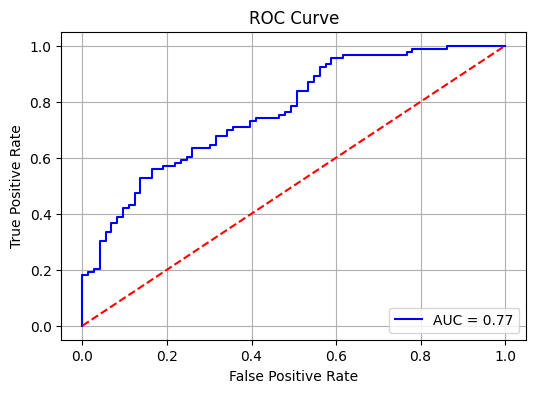

In [85]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1 (positive class)
y_proba = rand_frst_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


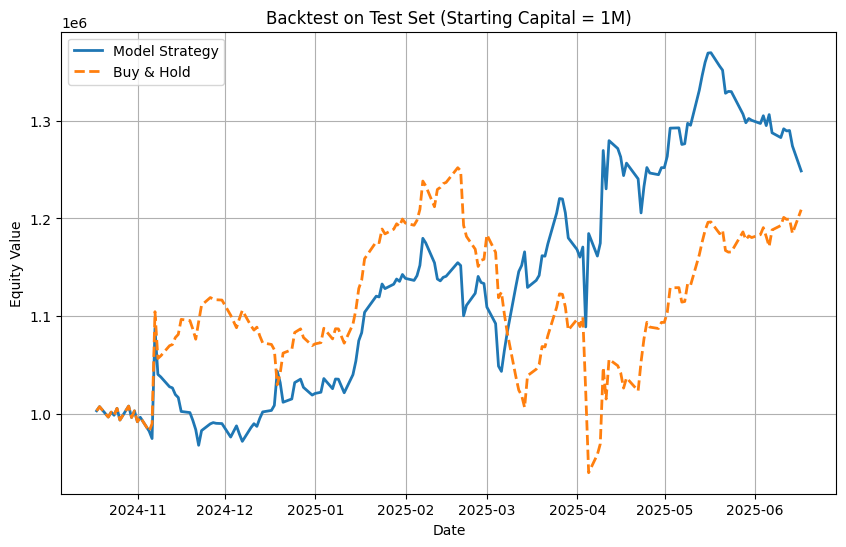

In [86]:
test_data = price_data.loc[X_test.index].copy()

# Compute log returns
test_data['LogRet'] = np.log(test_data['close'] / test_data['close'].shift(1))

# Compute strategy return (shift prediction so you act on signal)
test_data['Strategy_LogRet'] = test_data['Model_Pred'].shift(1) * test_data['LogRet']
test_data['BuyHold_LogRet'] = test_data['LogRet']

# Drop first row of test set (because of shift)
test_data.dropna(subset=['Strategy_LogRet'], inplace=True)

# Equity curve
initial_capital = 1_000_000
test_data['Strategy_Equity'] = initial_capital * np.exp(test_data['Strategy_LogRet'].cumsum())
test_data['BuyHold_Equity'] = initial_capital * np.exp(test_data['BuyHold_LogRet'].cumsum())

# Plot
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data['Strategy_Equity'], label='Model Strategy', linewidth=2)
plt.plot(test_data.index, test_data['BuyHold_Equity'], label='Buy & Hold', linewidth=2, linestyle='--')
plt.title('Backtest on Test Set (Starting Capital = 1M)')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.legend()
plt.grid(True)
plt.show()

- ลอง Backtesting
- ลอง ML ตัวอื่น
- เลือกใช้ indicators ที่เหมาะสม